In [1]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

from sklearn.model_selection import train_test_split
from keras.models import load_model

Using TensorFlow backend.


In [ ]:
input=["AWK","GOOG","SAP","TSLA","VFIAX"]
company=input[0]
df = pd.read_csv(company+".csv", engine='python')
df['Adj Close']

In [ ]:
input=["AWK","GOOG","SAP","TSLA","VFIAX"]
for i in input:
    company=i

    df = pd.read_csv(company+".csv", engine='python')
    df.tail()

    #setting index as date
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']

#     #plot
#     plt.figure(figsize=(16,8))
#     plt.plot(df['Close'], label='Close Price history')

    #importing required libraries
    from sklearn.preprocessing import MinMaxScaler
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, LSTM

    #creating dataframe
    data = df.sort_index(ascending=True, axis=0)
    new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
    for i in range(0,len(data)):
        new_data['Date'][i] = data['Date'][i]
        new_data['Close'][i] = data['Close'][i]

    #setting index
    new_data.index = new_data.Date
    new_data.drop('Date', axis=1, inplace=True)

    #creating train and test sets
    dataset = new_data.values

    train, valid = train_test_split(dataset, train_size=0.8, test_size=0.2, shuffle=False)
    # train = dataset[0:987,:]
    # valid = dataset[987:,:]

    #converting dataset into x_train and y_train
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    x_train, y_train = [], []
    for i in range(60,len(train)):
        x_train.append(scaled_data[i-60:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
    
    print("saving model...")
    model.save(company+' LSTM_model.h5')
    
    # Deletes the existing model
    del model  

    # Returns a compiled model identical to the previous one
    model = load_model(company+' LSTM_model.h5')

    #predicting 246 values, using past 60 from the train data
    inputs = new_data[len(new_data) - len(valid) - 60:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)

    X_test = []
    for i in range(60,inputs.shape[0]):
        X_test.append(inputs[i-60:i,0])
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)

    #Results

    rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
    rms

    #11.772259608962642
    #for plotting
    train = new_data[:len(train)]
    valid = new_data[len(train):]
    valid['Predictions'] = closing_price
    plt.figure()
    plt.plot(train['Close'])
    plt.plot(valid[['Close','Predictions']])
    plt.savefig(company+' pred_vs_real'+'.png')

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 164s - loss: 0.0019
saving model...


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Epoch 1/1
 - 165s - loss: 0.0040
saving model...
Epoch 1/1
 - 167s - loss: 0.0024
saving model...
Epoch 1/1


In [3]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train, valid = train_test_split(dataset, train_size=0.8, test_size=0.2, shuffle=False)
# train = dataset[0:987,:]
# valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

days_past=90

x_train, y_train = [], []
for i in range(days_past,len(train)):
    x_train.append(scaled_data[i-days_past:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 90 from the train data
inputs = new_data[len(new_data) - len(valid) - days_past:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(days_past,inputs.shape[0]):
    X_test.append(inputs[i-days_past:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

#Results

rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

#11.772259608962642

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 241s - loss: 0.0021


2.2832971840767047

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


TypeError: can only concatenate list (not "str") to list

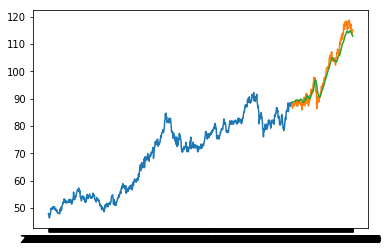

In [4]:
#for plotting
train = new_data[:len(train)]
valid = new_data[len(train):]
valid['Predictions'] = closing_price
plt.title(company+' Prediction vs Real Stock Price')
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.savefig(company+' pred_vs_real_90'+'.png')

In [16]:
for i in input:
    company=i
    print (i)

AWK
GOOG
SAP
TSLA
VFIAX
